In [938]:
import anndata
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kb_python.utils import import_matrix_as_anndata
from sklearn.linear_model import LinearRegression
from upsetplot import from_contents, from_indicators
from upsetplot import plot as upset
from scipy.stats import ttest_ind_from_stats
from mx.mx_inspect import mx_inspect_rows, mx_inspect_cols
from mx.mx_filter import mx_filter
from scipy.io import mmread
import anndata 
fsize = 15
import sys
import muon

def nd(arr):
    return np.asarray(arr).reshape(-1)


def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, c="k", alpha=0.75, zorder=0)
    ax.set(**{"aspect": "equal", "xlim": lims, "ylim": lims})
    return ax


plt.rcParams.update({"font.size": fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
blue = "#34CBBF"
red = "#CB3440"

In [943]:
ma = anndata.read_h5ad("/home/sina/projects/atac/scATAK/data/10xPBMC/mome_x/atac.h5ad")
mg = anndata.read_h5ad("/home/sina/projects/atac/scATAK/data/10xPBMC/mome_x/gene.h5ad")

In [946]:
(ma.obs.index.values != ma.obs.index.values).sum()

0

In [947]:
print(ma.shape, mg.shape,sep="\n")

(10970, 73976)
(10970, 73976)


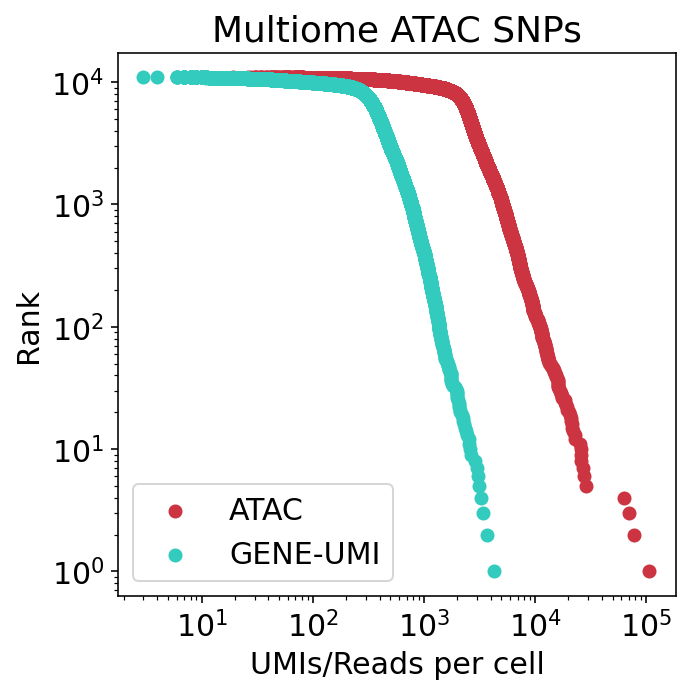

In [948]:
fig, ax = plt.subplots(figsize=(5,5))

x = ma.obs["counts_sum"].sort_values(ascending=False)
y = np.arange(x.shape[0])
ax.scatter(x,y, color=red, label="ATAC")

x = mg.obs["counts_sum"].sort_values(ascending=False)
y = np.arange(x.shape[0])
ax.scatter(x,y, color=blue, label="GENE-UMI")

ax.set(**{
    "xscale": "log",
    "yscale": "log",
    "xlabel": "UMIs/Reads per cell",
    "ylabel": "Rank",
    "title": "Multiome ATAC SNPs"
})
ax.legend()
fig.show()

In [949]:
print(mg.shape,ma.shape,sep="\n")

(10970, 73976)
(10970, 73976)


## Consensus Genotype

### on the ATAC data

In [950]:
ref = nd(ma.layers["ref"].sum(0))
alt = nd(ma.layers["alt"].sum(0))

# do the genotyping
e = 1e-4 # 0.0001
a = ref*np.log(1-e) + alt*np.log(e) # hom_alt (1 in sparse matrix)
b = (ref+alt)*np.log(0.5)           # het     (2 in sparse matrix)
c = ref*np.log(e) + alt*np.log(1-e) # hom_ref (3 in sparse matrix)
ll = np.array([a.data, b.data, c.data])

geno = a.copy()
amax = np.argmax(ll, axis=0)+1

magt = amax.copy()

### on the Gene data

In [951]:
ref = nd(mg.layers["ref"].sum(0))
alt = nd(mg.layers["alt"].sum(0))

# do the genotyping
e = 1e-4 # 0.0001
a = ref*np.log(1-e) + alt*np.log(e) # hom_alt (1 in sparse matrix)
b = (ref+alt)*np.log(0.5)           # het     (2 in sparse matrix)
c = ref*np.log(e) + alt*np.log(1-e) # hom_ref (3 in sparse matrix)
ll = np.array([a.data, b.data, c.data])

geno = a.copy()
amax = np.argmax(ll, axis=0)+1

mggt = amax.copy()

### Compare the snp calls

In [952]:
# All snp calls
(magt == mggt).sum()/mggt.shape[0]

0.886544284632854

### Compare het and hom snp calls separately

In [953]:
hommask = np.logical_and(magt != 2, mggt != 2)
hetmask = np.logical_or(magt == 2, mggt == 2)
hetmask_same = np.logical_and(magt == mggt, hetmask)

homsnps = fmg.var[hommask].index.values
hetsnps = fmg.var[hetmask].index.values
hetsnps_same = fmg.var[hetmask_same].index.values

In [954]:
# Homozygous SNP calls
(magt[hommask] == mggt[hommask]).sum()/hommask.sum()

0.9917319235202926

In [955]:
# Heterozygous SNP calls
(magt[hetmask] == mggt[hetmask]).sum()/hetmask.sum()

0.6628771870509678

In [956]:
mg.obs["het_ref_gene_sum"] = nd(mg.layers["ref"][:,hetmask].sum(1))
mg.obs["het_alt_gene_sum"] = nd(mg.layers["alt"][:,hetmask].sum(1))
ma.obs["het_ref_atac_sum"] = nd(ma.layers["ref"][:,hetmask].sum(1))
ma.obs["het_alt_atac_sum"] = nd(ma.layers["alt"][:,hetmask].sum(1))
mg.obs["het_ref_atac_sum"] =    ma.obs["het_ref_atac_sum"]
mg.obs["het_alt_atac_sum"] =    ma.obs["het_alt_atac_sum"]

In [957]:
mg.obs.groupby("cluster")[[
    "het_ref_gene_sum",
    "het_alt_gene_sum",
    "het_ref_atac_sum",
    "het_alt_atac_sum"]].mean()

,het_ref_gene_sum,het_alt_gene_sum,het_ref_atac_sum,het_alt_atac_sum
cluster,,,,
1,54.260371,41.668122,73.399563,69.495087
2,75.910194,60.464401,102.775081,93.660194
3,69.740895,57.024974,84.003122,76.104058
4,11.699681,9.175719,43.301384,39.601704
5,58.289274,46.661972,71.689057,66.061755
6,107.454649,81.883220,109.158730,93.651927
7,46.496160,38.101382,149.649770,116.344086
8,77.498322,61.647651,116.414430,97.927852
9,58.582868,47.893855,84.251397,75.789572


In [ ]:
# hunt for snps

In [958]:
assignments = mg.obs.cluster.values
unique = np.unique(assignments)
refmat = mg.layers["ref"][:,hetmask_same].A
altmat = mg.layers["alt"][:,hetmask_same].A

gdfs = []
for u in unique:
    mask = assignments == u
    t_mat = refmat[mask]
    c_mat = altmat[mask]
    refs = t_mat.sum(0)
    alts = c_mat.sum(0)
    ratio = refs/alts
    rank = np.argsort(ratio)
    tmp = pd.DataFrame({
        "name": hetsnps_same,
        # "rank": rank,
        "group": u,
        "alt_sum": alts,
        "ref_sum": refs,
        "total_sum": alts + refs
    })
    gdfs.append(tmp)
    
gdf = pd.concat(gdfs)

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [959]:
assignments = mg.obs.cluster.values
unique = np.unique(assignments)
refmat = ma.layers["ref"][:,hetmask_same].A
altmat = ma.layers["alt"][:,hetmask_same].A

adfs = []
for u in unique:
    mask = assignments == u
    t_mat = refmat[mask]
    c_mat = altmat[mask]
    refs = t_mat.sum(0)
    alts = c_mat.sum(0)
    ratio = refs/alts
    rank = np.argsort(ratio)
    tmp = pd.DataFrame({
        "name": hetsnps_same,
        # "rank": rank,
        "group": u,
        "alt_sum": alts,
        "ref_sum": refs,
        "total_sum": alts + refs
    })
    adfs.append(tmp)
    
adf = pd.concat(adfs)

/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/sina/bin/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [960]:
df = pd.concat([
    adf.add_prefix("atac_").rename(columns={"atac_group":"group", "atac_name": "name"}), 
    gdf.add_prefix("gene_").drop(columns=["gene_name", "gene_group"])
], axis=1)

In [961]:
df

,name,group,atac_alt_sum,atac_ref_sum,atac_total_sum,gene_alt_sum,gene_ref_sum,gene_total_sum
0,rs12184331,1,3.0,1.0,4.0,6.0,0.0,6.0
1,rs9329410,1,5.0,4.0,9.0,0.0,1.0,1.0
2,rs1240743,1,0.0,2.0,2.0,1.0,1.0,2.0
3,rs819978,1,1.0,1.0,2.0,1.0,2.0,3.0
4,rs6656541,1,1.0,1.0,2.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...
15680,rs195217,16,0.0,0.0,0.0,1.0,0.0,1.0
15681,rs74703271,16,6.0,1.0,7.0,3.0,0.0,3.0
15682,rs6643809,16,5.0,16.0,21.0,0.0,4.0,4.0
15683,rs10217886,16,0.0,1.0,1.0,0.0,0.0,0.0


In [962]:
min_atac = 10
min_gene = 10

fdf = df.query(
    f"((atac_ref_sum == 0 & atac_alt_sum != 0) | (atac_ref_sum != 0 & atac_alt_sum == 0)) & (atac_total_sum > {min_atac} & gene_total_sum > {min_gene})"
)[["name", "group", "atac_ref_sum", "atac_alt_sum", "gene_ref_sum", "gene_alt_sum", "atac_total_sum", "gene_total_sum"]]

fdf["atac_ref_bool"] = (fdf["atac_ref_sum"] > 0).astype("category")
fdf["gene_ref_ratio"] = fdf["gene_ref_sum"] / (fdf["gene_ref_sum"] + fdf["gene_alt_sum"])
fdf["name_group"] = fdf["name"] + "_" + fdf["group"].astype(str)

d = fdf.groupby(["atac_ref_bool", "name"]) ["gene_ref_sum"].sum().unstack()

d1 = fdf.groupby(["atac_ref_bool", "name"]) ["gene_ref_sum"].sum().unstack()
d2 = fdf.groupby(["atac_ref_bool", "name"]) ["gene_alt_sum"].sum().unstack()

d = d1 / (d1 + d2)

data = [d.iloc[0][d.notna().iloc[0]].values, 
        d.iloc[1][d.notna().iloc[1]].values]

In [963]:
((fdf["atac_ref_sum"] > 0) == 
 (fdf["gene_ref_sum"]  > fdf["gene_alt_sum"])
).sum()/fdf.shape[0]

0.9026548672566371

In [964]:
fdf.shape

(113, 11)

In [966]:
# number of hetsnps per group vs number of clusters in the group
pd.concat([
    fdf.groupby("group")["name"].count(), 
    ma.obs.value_counts("cluster")
], axis=1).rename(columns={"name": "nsnps", 0: "cluster_size"})

,nsnps,cluster_size
1,13.0,1097
2,9.0,1001
3,12.0,916
4,NaN,859
5,10.0,828
6,19.0,770
7,7.0,763
8,8.0,675
9,3.0,607
10,8.0,555


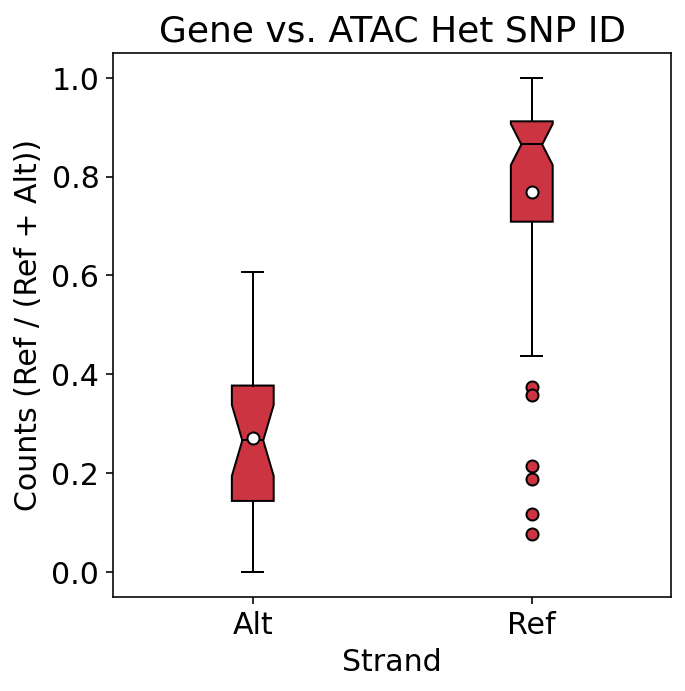

In [967]:
fig, ax = plt.subplots(figsize=(5,5))
labels = ["Alt", "Ref"]
x = np.array([1,2])

ax.boxplot(data, positions=np.arange(len(labels)), 
           patch_artist=True, notch=True,
           boxprops=dict(facecolor=red), 
           medianprops=dict(color="k"),
           flierprops=dict(markerfacecolor=red, markeredgecolor='k')
          )

means = [data[0].mean(), data[1].mean()]
mean_line = ax.scatter(
    np.arange(x.shape[0]),
    means,
    color="k",
    label="mean",
    linewidth=3,
    marker="_",
    zorder=10
)

# means dot
mean_dot = ax.scatter(
    np.arange(x.shape[0]),
    means,
    facecolor="white",
    edgecolor="k",
    label="mean",
    zorder=10
)


ax.set(**{
    "title": "Gene vs. ATAC Het SNP ID",
    "xlabel": "Strand",
    "ylabel": "Counts (Ref / (Ref + Alt))",
    "xticklabels": labels,

})
#fig.savefig("figures/ase_celltype.png", dpi=300, bbox_inches="tight")
fig.show()

In [968]:
fma.obs.eval("cluster == 1").sum()

1097

In [969]:
cluster_id = 1

bc_mask = mg.obs.eval(f"cluster == {cluster_id}")
bcs = mg.obs.query(f"cluster == {cluster_id}").index

ca_ref = pd.DataFrame(
    ma.layers["ref"][bc_mask][:,hetmask_same].A,
    columns=hetsnps_same,
    index=bcs
)

ca_alt = pd.DataFrame(
    ma.layers["alt"][bc_mask][:,hetmask_same].A,
    columns=hetsnps_same,
    index=bcs
)

cg_ref = pd.DataFrame(
    mg.layers["ref"][bc_mask][:,hetmask_same].A,
    columns=hetsnps_same,
    index=bcs
)

cg_alt = pd.DataFrame(
    mg.layers["alt"][bc_mask][:,hetmask_same].A,
    columns=hetsnps_same,
    index=bcs
)

In [970]:
print(ca_ref.shape, ca_alt.shape, cg_ref.shape, cg_alt.shape, sep="\n")

(1832, 15685)
(1832, 15685)
(1832, 15685)
(1832, 15685)


In [971]:
min_atac = 2
min_gene = 2

# data in either alt or ref or both
anzero_mask = np.logical_or(ca_ref > min_atac, ca_alt > min_atac)
gnzero_mask = np.logical_or(cg_ref > min_gene, cg_alt > min_gene)

anzero = anzero_mask.sum()
gnzero = gnzero_mask.sum()

both = np.logical_and(anzero_mask, gnzero_mask).sum()

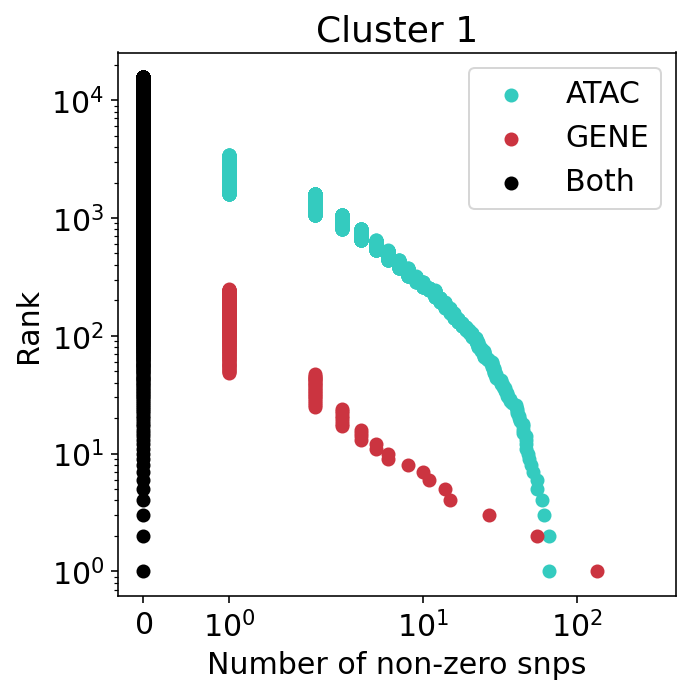

In [972]:
fig, ax = plt.subplots(figsize=(5,5))

x = np.sort(anzero.values)[::-1]
y = np.arange(x.shape[0])
ax.scatter(x,y, color=blue, label="ATAC")

x = np.sort(gnzero.values)[::-1]
y = np.arange(x.shape[0])
ax.scatter(x,y, color=red, label="GENE")

x = np.sort(both.values)[::-1]
y = np.arange(x.shape[0])
ax.scatter(x,y, color="k", label="Both")

ax.set(**{
    "xscale": "symlog",
    "yscale": "log",
    "xlabel": "Number of non-zero snps",
    "ylabel": "Rank",
    "title" : f"Cluster {cluster_id}"
})
ax.legend()
fig.show()

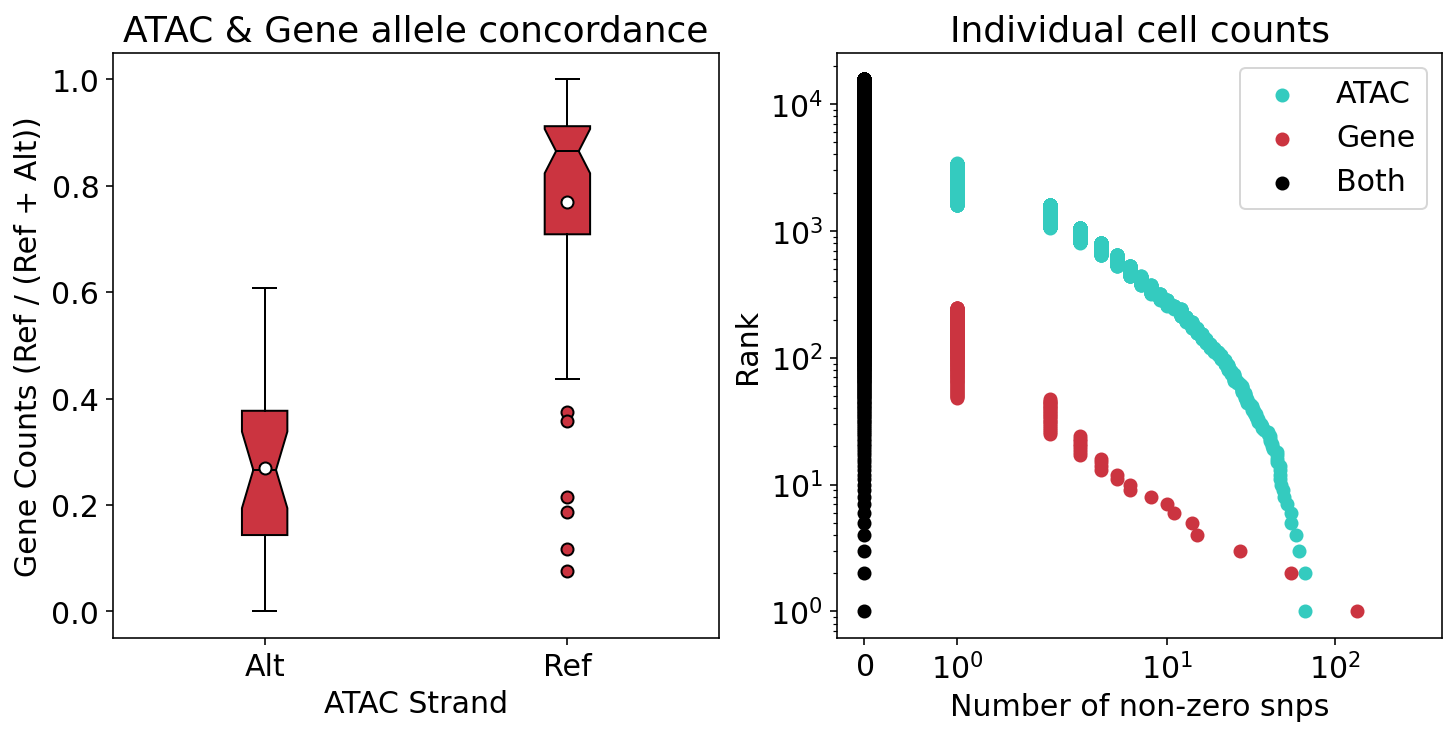

In [973]:
fig, axs = plt.subplots(figsize=(10,5), ncols=2, constrained_layout=True)

ax = axs[0]
labels = ["Alt", "Ref"]
x = np.array([1,2])

ax.boxplot(data, positions=np.arange(len(labels)), 
           patch_artist=True, notch=True,
           boxprops=dict(facecolor=red), 
           medianprops=dict(color="k"),
           flierprops=dict(markerfacecolor=red, markeredgecolor='k')
          )

means = [data[0].mean(), data[1].mean()]
mean_line = ax.scatter(
    np.arange(x.shape[0]),
    means,
    color="k",
    label="mean",
    linewidth=3,
    marker="_",
    zorder=10
)

# means dot
mean_dot = ax.scatter(
    np.arange(x.shape[0]),
    means,
    facecolor="white",
    edgecolor="k",
    label="mean",
    zorder=10
)


ax.set(**{
    "title": "ATAC & Gene allele concordance",
    "xlabel": "ATAC Strand",
    "ylabel": "Gene Counts (Ref / (Ref + Alt))",
    "xticklabels": labels,

})

ax = axs[1]
x = np.sort(anzero.values)[::-1]
y = np.arange(x.shape[0])
ax.scatter(x,y, color=blue, label="ATAC")

x = np.sort(gnzero.values)[::-1]
y = np.arange(x.shape[0])
ax.scatter(x,y, color=red, label="Gene")

x = np.sort(both.values)[::-1]
y = np.arange(x.shape[0])
ax.scatter(x,y, color="k", label="Both")

ax.set(**{
    "xscale": "symlog",
    "yscale": "log",
    "xlabel": "Number of non-zero snps",
    "ylabel": "Rank",
    "title" : f"Individual cell counts"
})
ax.legend()

fig.savefig("figures/ase_tradeoff.png", dpi=300, bbox_inches="tight")
fig.show()